MBTdelay -- model_LightGBM.ipynb 

© Mark Mace 2019 markfmace@gmail.com 

Performs LightGBM based machine learning on MBTDelay datasets

In [1]:
# GENERAL INCLUSIONS
import numpy as np
import glob,os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


# FOR DATES AND TIMES #
import time
import datetime
from dateutil import tz
from datetime import timedelta
import arrow

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# CONVERT UNIX (utc) TIMESTAMP TO YYYY-mm-dd HH:MM:SS (EASTERN)
def conv_unixts_to_east_hms(ts):
    east=arrow.Arrow.fromtimestamp(ts).to('US/Eastern')
    return east.format('YYYY-MM-DD HH:mm:ss')

def get_hour(dt_str):
    return dt_str[11:13]

def get_month_num(dt_str):
    return dt_str[5:7]


# RETURNS DAY OF WEEK 
# M-0, Tu-1, W-2, Th-3 F-4 Sa-6 Su-7
# TAKES YYYY-MM-DD HH:MM:SS RETURNS Day (IN WHATEVER TIMEZONE)
def get_day_of_week(dt):
    dtt = arrow.get(dt)
    return dtt.weekday()

# TAKES UNIX TS RETURNS Day (IN EASTERN/BOSTON)
def get_day_of_week_east_unix(ts):
    east=conv_unixts_to_east_hms(ts)
    return get_day_of_week(east)
    
# TAKES UNIX TS RETURNS Day (IN UTC)
def get_day_of_week_utc_unix(ts):
    utc=conv_unixts_to_utc_hms(ts)
    return get_day_of_week(utc)
    


In [3]:
# another self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


In [4]:
### ML SPECIFIC FUNCTIONS
### FOR FEATURE ENGINEERING
# ENCODE EVENT -- 1--event, 0--no event
def bin_event(x):
    x=int(x)
    if(x!=0):
        return 1
    else:
        return 0

# YES OR NO 
def bin_weather(x):
    x=float(x)
    if(x>0):
        return 1
    else:
        return 0
    
# BIN PRECIPITATION TYPE
def bin_ptype(x):
    if(x==1): # None
        return 0
    else: # rain, snow or sleet
        return 0
    
# BIN IN d_bin SECONDS
d_bin=10
def bin_delay(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/d_bin)
    
#BIN IN t_bin DEGREES
t_bin=10
def bin_temp(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/t_bin)
    
        
# PEAK HOUR BIN
def bin_peak(x):
    x=float(x)
    if(6<=x<=10 or 4<=x<=7):
        return 1
    else:
        return 0
           
# WEEKDAY BIN
def bin_weekday(x):
    x=float(x)
    if(x<5):
        return 1 # WEEKDAY
    else:
        return 0 # WEEKEND
    
# SEASON
def bin_season(x):
    x=float(x)
    if(x in {1,2,12}):
        return 0 # WINTER
    elif(x in {3,4,5}):
        return 1 # SPRING
    elif(x in {9,10,11}):
        return 2 # FALL
    elif(x in {6,7,8}):
        return 3 # SUMMER
    else:
        print("NOT A VALID MONTH")
        return -1 # WRONG

In [5]:
# GET DATASETS FROM PRECOMPUTED FILES
MBTdelay_df=[]
ds_files=glob.glob("DS/DS_*.csv")
for ds_f in ds_files:

    station_name,station_id=ds_f.replace("DS/DS_","").replace(".csv","").split("_")
    df_temp=pd.read_csv(ds_f)
    df_temp = df_temp[np.isfinite(df_temp['HEAD_GAP'])]

    MBTdelay_df.append([station_name,station_id,df_temp])
    
MBTdelay_df=np.array(MBTdelay_df)


Feature engineer dataset and perform train-test split based on a number of different criteria
input is dataframe and flags (0--no FE, 1--FE)

In [6]:
# RESULTS OF THE FUNCTION BELOW #
f_combo_1=[0,0,1,0,1,0,1,0,0]
f_combo_2=[0,1,1,0,1,0,0,0,0] # <-- THIS IS THE BEST COMBO

# FEATURE ENGINEER DATA AND PERFORM TRAIN-TEST SPLIT
def feature_engineer_and_split(loc_df,EVENT_FLAG,SNOW_YN_FLAG,RAIN_YN_FLAG,
          WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG,TEMP_FLAG,split_perc,shuffle_flag):
    
#     print(np.mean(test_df['HEAD_GAP']))
    fe_df=loc_df[np.isfinite(loc_df['TEMP'])].copy()

    if(EVENT_FLAG==1):
        fe_df['event']=fe_df['event'].apply(lambda x: bin_weather(x))

    if(SNOW_YN_FLAG==1):
        fe_df['PRECIP_ACC']=fe_df['PRECIP_ACC'].apply(lambda x: bin_weather(x))

    if(RAIN_YN_FLAG==1):
        fe_df['PRECIP_INT']=fe_df['PRECIP_INT'].apply(lambda x: bin_weather(x))

    if(WEEKDAY_FLAG==1):
        fe_df['DOW']=fe_df['DOW'].apply(lambda x: bin_weekday(x))
        
    if(PRECIP_TYP_FLAG==1):
        fe_df['PRECIP_TYP_ENC']=fe_df['PRECIP_TYP_ENC'].apply(lambda x: bin_ptype(x))

    if(PEAK_FLAG==1):
        fe_df['HOUR_BIN']=fe_df['HOUR_BIN'].apply(lambda x: bin_peak(x))

    if(DELAY_FLAG==1):
        fe_df['HEAD_GAP']=fe_df['HEAD_GAP'].apply(lambda x: bin_delay(x))

    if(SEASON_FLAG==1):
        fe_df['MONTH_BIN']=fe_df['MONTH_BIN'].apply(lambda x: bin_season(x))
        
    if(TEMP_FLAG==1):
        fe_df['TEMP']=fe_df['TEMP'].apply(lambda x: bin_temp(x))

    # NOT INCLUDING PRECIP TYPE #
    all_x=np.transpose(np.array([fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],
                                fe_df['event'],
                                fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], 
                                fe_df['PRECIP_PRO'], fe_df['TEMP']],dtype=np.float32))

    all_y=np.array([fe_df['HEAD_GAP']],dtype=np.float32)[0]


    X_train, X_test, y_train, y_test = train_test_split(all_x, all_y, test_size=split_perc, random_state=0,shuffle=shuffle_flag)
    
    return X_train, X_test, y_train, y_test 


In [7]:
## THIS IS JUST FOR TESTING ##

# TEST STATION NUMBER # 
station_num_id=25

test_size=0.2

# LOCAL DATAFRAME
df_loc=MBTdelay_df[station_num_id][2]
df_loc = df_loc[np.isfinite(df_loc['HEAD_GAP'])]

X_train, X_test, y_train, y_test=feature_engineer_and_split(df_loc, 0,1,1,0,1,0,1,0,0, test_size,False)

# CREATE DATASET FOR LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# SPECIFY PARAMETERS
params = {
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'objective': 'regression',
            'num_leaves': 20, 
            'n_estimators': 100, 
            'learning_rate': 0.1, 
                }

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The rae of prediction is:', rae(y_test, y_pred)[1])
print('Variance score: ',r2_score(y_test,y_pred))


Starting training...
[1]	valid_0's rmse: 22.9044
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 21.6258
[3]	valid_0's rmse: 20.5136
[4]	valid_0's rmse: 19.57
[5]	valid_0's rmse: 18.6578
[6]	valid_0's rmse: 17.9571
[7]	valid_0's rmse: 17.3574
[8]	valid_0's rmse: 16.7518
[9]	valid_0's rmse: 16.3094
[10]	valid_0's rmse: 15.8623
[11]	valid_0's rmse: 15.5446
[12]	valid_0's rmse: 15.2434
[13]	valid_0's rmse: 15.0144
[14]	valid_0's rmse: 14.7974
[15]	valid_0's rmse: 14.6303
[16]	valid_0's rmse: 14.5101
[17]	valid_0's rmse: 14.3441
[18]	valid_0's rmse: 14.2449
[19]	valid_0's rmse: 14.1594
[20]	valid_0's rmse: 14.1106
[21]	valid_0's rmse: 14.0458
[22]	valid_0's rmse: 13.9759
[23]	valid_0's rmse: 13.9245
[24]	valid_0's rmse: 13.921
[25]	valid_0's rmse: 13.8846
[26]	valid_0's rmse: 13.85
[27]	valid_0's rmse: 13.8111
[28]	valid_0's rmse: 13.7483
[29]	valid_0's rmse: 13.73
[30]	valid_0's rmse: 13.746
[31]	valid_0's rmse: 13.7826
[32]	valid_0's rmse: 13.7636
[33]	va

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Determine model parameters for each station using fixed parameters

In [9]:
# BUFFERS FOR ANALYTICS
data_metrics=[]
model_outcomes=[]

# TRAIN-TEST SPLIT
test_size=0.2

# PARAMETERS DETERMINED FROM CV SCAN 
params_prod = {
                'boosting_type': 'gbdt',
                'metric': 'rmse',
                'objective': 'regression',
                'num_leaves': 40, 
                'num_iterations': 50, 
                'learning_rate': 0.05, 
                'boosting': 'gbdt'
              }

# RUN MODEL FOR ALL STATIOS AND SAVE TO FILE #
for station_num_id in range(len(MBTdelay_df)):
    
    # LOAD DATAFRAME 
    station_name=MBTdelay_df[station_num_id][0]
    station_id=MBTdelay_df[station_num_id][1]
    test_df=MBTdelay_df[station_num_id][2].copy()

    # SIMPLE STATS FOR DATA FOR A STATION
    gap_mode=stats.mode(test_df['HEAD_GAP'].values)
    gap_mean=np.mean(test_df['HEAD_GAP'])
    gap_mean_unc=np.std(test_df['HEAD_GAP'])/np.sqrt(len(test_df['HEAD_GAP']))
    
    # SAVE METRICS TO ARRAY 
    data_metrics.append([station_name,station_id,
                    gap_mode,
                    gap_mean,
                    gap_mean_unc
                    ])
    
    # GENERATE TEST-TRAIN SPLIT -- USES FEATURE ENGINEERING DETERMINED PREVIOUSLY #
    X_train, X_test, y_train, y_test=feature_engineer_and_split(test_df, 0,1,1,0,1,0,1,0,0, test_size,True)
    
    # CREATE DATASET FOR LIGHTGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


    print('Starting training...')
    # TRAIN
    gbm = lgb.train(params_prod,
                    lgb_train,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10)

    print('Saving model...')
    # SAVE MODEL TO FILE
    gbm.save_model('LGB_MODEL/'+station_name+'_'+station_id+'.txt')

    print('Starting predicting...')
    # PERFORM PREDICTION FOR METRICS
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  
    # EVALUATE METRICS
    mae=metrics.mean_absolute_error(y_test, y_pred)
    mse=metrics.mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2=r2_score(y_test,y_pred)
    
    # SAVE MODEL METRICS
    model_outcomes.append([station_name,station_id,mae,mse,rmse,r2])

model_outcomes=np.array(model_outcomes)

mo_df=pd.DataFrame({'station_name': model_outcomes[:, 0], 
                    'station_id': model_outcomes[:, 1], 
                    'mae': model_outcomes[:, 2], 
                    'mse': model_outcomes[:, 3], 
                    'rmse': model_outcomes[:, 4], 
                    'r2': model_outcomes[:, 5]})

mo_df.to_csv('LGB_MODEL/Outcomes.csv')

Starting training...
[1]	valid_0's rmse: 5.82866
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 5.82069
[3]	valid_0's rmse: 5.81387
[4]	valid_0's rmse: 5.80692
[5]	valid_0's rmse: 5.80042
[6]	valid_0's rmse: 5.79572
[7]	valid_0's rmse: 5.79028
[8]	valid_0's rmse: 5.78667
[9]	valid_0's rmse: 5.78252
[10]	valid_0's rmse: 5.77903
[11]	valid_0's rmse: 5.77611
[12]	valid_0's rmse: 5.77376
[13]	valid_0's rmse: 5.77022
[14]	valid_0's rmse: 5.76711
[15]	valid_0's rmse: 5.76415
[16]	valid_0's rmse: 5.76266
[17]	valid_0's rmse: 5.76037
[18]	valid_0's rmse: 5.75828
[19]	valid_0's rmse: 5.75722
[20]	valid_0's rmse: 5.75575
[21]	valid_0's rmse: 5.75463
[22]	valid_0's rmse: 5.7537
[23]	valid_0's rmse: 5.7528
[24]	valid_0's rmse: 5.75265
[25]	valid_0's rmse: 5.75266
[26]	valid_0's rmse: 5.75053
[27]	valid_0's rmse: 5.7501
[28]	valid_0's rmse: 5.74916
[29]	valid_0's rmse: 5.74802
[30]	valid_0's rmse: 5.74812
[31]	valid_0's rmse: 5.74713
[32]	valid_0's rmse: 5.74736
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 14.671
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 14.5445
[3]	valid_0's rmse: 14.4332
[4]	valid_0's rmse: 14.3341
[5]	valid_0's rmse: 14.2424
[6]	valid_0's rmse: 14.1572
[7]	valid_0's rmse: 14.0823
[8]	valid_0's rmse: 14.0131
[9]	valid_0's rmse: 13.9488
[10]	valid_0's rmse: 13.8957
[11]	valid_0's rmse: 13.8391
[12]	valid_0's rmse: 13.7982
[13]	valid_0's rmse: 13.7596
[14]	valid_0's rmse: 13.7299
[15]	valid_0's rmse: 13.6964
[16]	valid_0's rmse: 13.6678
[17]	valid_0's rmse: 13.6357
[18]	valid_0's rmse: 13.6142
[19]	valid_0's rmse: 13.5957
[20]	valid_0's rmse: 13.5747
[21]	valid_0's rmse: 13.5564
[22]	valid_0's rmse: 13.5418
[23]	valid_0's rmse: 13.5264
[24]	valid_0's rmse: 13.5094
[25]	valid_0's rmse: 13.4983
[26]	valid_0's rmse: 13.4848
[27]	valid_0's rmse: 13.4781
[28]	valid_0's rmse: 13.4686
[29]	valid_0's rmse: 13.4576
[30]	valid_0's rmse: 13.4502
[31]	valid_0's rmse: 13.4483
[32]	valid_0's rmse: 13.4419

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 6.80574
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 6.78122
[3]	valid_0's rmse: 6.76306
[4]	valid_0's rmse: 6.74633
[5]	valid_0's rmse: 6.72736
[6]	valid_0's rmse: 6.71263
[7]	valid_0's rmse: 6.69969
[8]	valid_0's rmse: 6.69046
[9]	valid_0's rmse: 6.68017
[10]	valid_0's rmse: 6.67385
[11]	valid_0's rmse: 6.66753
[12]	valid_0's rmse: 6.66585
[13]	valid_0's rmse: 6.65404
[14]	valid_0's rmse: 6.6532
[15]	valid_0's rmse: 6.64896
[16]	valid_0's rmse: 6.64918
[17]	valid_0's rmse: 6.64785
[18]	valid_0's rmse: 6.65059
[19]	valid_0's rmse: 6.64872
[20]	valid_0's rmse: 6.64401
[21]	valid_0's rmse: 6.64134
[22]	valid_0's rmse: 6.64444
[23]	valid_0's rmse: 6.6463
[24]	valid_0's rmse: 6.64319
[25]	valid_0's rmse: 6.63949
[26]	valid_0's rmse: 6.63505
[27]	valid_0's rmse: 6.63438
[28]	valid_0's rmse: 6.63279
[29]	valid_0's rmse: 6.63798
[30]	valid_0's rmse: 6.63956
[31]	valid_0's rmse: 6.63784
[32]	valid_0's rmse: 6.63468


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.5848
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.5187
[3]	valid_0's rmse: 16.459
[4]	valid_0's rmse: 16.4056
[5]	valid_0's rmse: 16.3577
[6]	valid_0's rmse: 16.3154
[7]	valid_0's rmse: 16.276
[8]	valid_0's rmse: 16.2421
[9]	valid_0's rmse: 16.2102
[10]	valid_0's rmse: 16.1804
[11]	valid_0's rmse: 16.1512
[12]	valid_0's rmse: 16.1304
[13]	valid_0's rmse: 16.1026
[14]	valid_0's rmse: 16.0844
[15]	valid_0's rmse: 16.0682
[16]	valid_0's rmse: 16.0534
[17]	valid_0's rmse: 16.0446
[18]	valid_0's rmse: 16.033
[19]	valid_0's rmse: 16.0226
[20]	valid_0's rmse: 16.0174
[21]	valid_0's rmse: 16.0134
[22]	valid_0's rmse: 15.9997
[23]	valid_0's rmse: 15.9913
[24]	valid_0's rmse: 15.9808
[25]	valid_0's rmse: 15.9754
[26]	valid_0's rmse: 15.9747
[27]	valid_0's rmse: 15.9668
[28]	valid_0's rmse: 15.9608
[29]	valid_0's rmse: 15.9601
[30]	valid_0's rmse: 15.9586
[31]	valid_0's rmse: 15.9513
[32]	valid_0's rmse: 15.9453
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[44]	valid_0's rmse: 15.9036
[45]	valid_0's rmse: 15.904
[46]	valid_0's rmse: 15.9022
[47]	valid_0's rmse: 15.9011
[48]	valid_0's rmse: 15.8989
[49]	valid_0's rmse: 15.8987
[50]	valid_0's rmse: 15.8949
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.8949
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 13.1938
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 13.1403
[3]	valid_0's rmse: 13.0959
[4]	valid_0's rmse: 13.059
[5]	valid_0's rmse: 13.0212
[6]	valid_0's rmse: 12.9854
[7]	valid_0's rmse: 12.953
[8]	valid_0's rmse: 12.9279
[9]	valid_0's rmse: 12.9026
[10]	valid_0's rmse: 12.8797
[11]	valid_0's rmse: 12.8625
[12]	valid_0's rmse: 12.8456
[13]	valid_0's rmse: 12.8301
[14]	valid_0's rmse: 12.8115
[15]	valid_0's rmse: 12.7996
[16]	valid_0's rmse: 12.7832
[17]	valid_0's rmse: 12.7741
[18]	valid_0's rmse: 12.7642
[19]	valid_0's rmse: 12.7553
[20]	valid_0's rmse: 12.7495
[21]	valid_0's rmse: 12.7368


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 10.7598
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 10.7344
[3]	valid_0's rmse: 10.714
[4]	valid_0's rmse: 10.6955
[5]	valid_0's rmse: 10.6796
[6]	valid_0's rmse: 10.6594
[7]	valid_0's rmse: 10.6473
[8]	valid_0's rmse: 10.637
[9]	valid_0's rmse: 10.6287
[10]	valid_0's rmse: 10.6213
[11]	valid_0's rmse: 10.612
[12]	valid_0's rmse: 10.6085
[13]	valid_0's rmse: 10.6051
[14]	valid_0's rmse: 10.6003
[15]	valid_0's rmse: 10.6007
[16]	valid_0's rmse: 10.6028
[17]	valid_0's rmse: 10.597
[18]	valid_0's rmse: 10.5972
[19]	valid_0's rmse: 10.591
[20]	valid_0's rmse: 10.5872
[21]	valid_0's rmse: 10.5877
[22]	valid_0's rmse: 10.5935
[23]	valid_0's rmse: 10.5928
[24]	valid_0's rmse: 10.5923
[25]	valid_0's rmse: 10.5945
[26]	valid_0's rmse: 10.5949
[27]	valid_0's rmse: 10.5935
[28]	valid_0's rmse: 10.5989
[29]	valid_0's rmse: 10.5993
[30]	valid_0's rmse: 10.6043
Early stopping, best iteration is:
[20]	valid_0's rmse: 10.58

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 6.99188
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 6.97098
[3]	valid_0's rmse: 6.94991
[4]	valid_0's rmse: 6.93155
[5]	valid_0's rmse: 6.91734
[6]	valid_0's rmse: 6.90338
[7]	valid_0's rmse: 6.88845
[8]	valid_0's rmse: 6.87674
[9]	valid_0's rmse: 6.86569
[10]	valid_0's rmse: 6.85597
[11]	valid_0's rmse: 6.84286
[12]	valid_0's rmse: 6.83404
[13]	valid_0's rmse: 6.82426
[14]	valid_0's rmse: 6.81832
[15]	valid_0's rmse: 6.81435
[16]	valid_0's rmse: 6.80566
[17]	valid_0's rmse: 6.80158
[18]	valid_0's rmse: 6.79525
[19]	valid_0's rmse: 6.78878
[20]	valid_0's rmse: 6.78479
[21]	valid_0's rmse: 6.78185
[22]	valid_0's rmse: 6.77484
[23]	valid_0's rmse: 6.76907
[24]	valid_0's rmse: 6.76604
[25]	valid_0's rmse: 6.7623
[26]	valid_0's rmse: 6.75835
[27]	valid_0's rmse: 6.75684
[28]	valid_0's rmse: 6.7531
[29]	valid_0's rmse: 6.75121
[30]	valid_0's rmse: 6.75196
[31]	valid_0's rmse: 6.75262
[32]	valid_0's rmse: 6.7492
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.4692
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.4193
[3]	valid_0's rmse: 16.3802
[4]	valid_0's rmse: 16.3397
[5]	valid_0's rmse: 16.3078
[6]	valid_0's rmse: 16.2746
[7]	valid_0's rmse: 16.2489
[8]	valid_0's rmse: 16.2219
[9]	valid_0's rmse: 16.2018
[10]	valid_0's rmse: 16.1823
[11]	valid_0's rmse: 16.1584
[12]	valid_0's rmse: 16.1418
[13]	valid_0's rmse: 16.1301
[14]	valid_0's rmse: 16.1124
[15]	valid_0's rmse: 16.0995
[16]	valid_0's rmse: 16.0864
[17]	valid_0's rmse: 16.0758
[18]	valid_0's rmse: 16.0616
[19]	valid_0's rmse: 16.0544
[20]	valid_0's rmse: 16.0458
[21]	valid_0's rmse: 16.0386
[22]	valid_0's rmse: 16.0288
[23]	valid_0's rmse: 16.0229
[24]	valid_0's rmse: 16.0228
[25]	valid_0's rmse: 16.0153
[26]	valid_0's rmse: 16.0069
[27]	valid_0's rmse: 15.9982
[28]	valid_0's rmse: 15.9971
[29]	valid_0's rmse: 15.9943
[30]	valid_0's rmse: 15.9897
[31]	valid_0's rmse: 15.9876
[32]	valid_0's rmse: 15.985

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 11.89
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 11.8584
[3]	valid_0's rmse: 11.828
[4]	valid_0's rmse: 11.8071
[5]	valid_0's rmse: 11.7848
[6]	valid_0's rmse: 11.763
[7]	valid_0's rmse: 11.7423
[8]	valid_0's rmse: 11.7299
[9]	valid_0's rmse: 11.7175
[10]	valid_0's rmse: 11.7039
[11]	valid_0's rmse: 11.6927
[12]	valid_0's rmse: 11.6813
[13]	valid_0's rmse: 11.6682
[14]	valid_0's rmse: 11.6554
[15]	valid_0's rmse: 11.6408
[16]	valid_0's rmse: 11.6351
[17]	valid_0's rmse: 11.6255
[18]	valid_0's rmse: 11.6167
[19]	valid_0's rmse: 11.6102
[20]	valid_0's rmse: 11.6073
[21]	valid_0's rmse: 11.6034
[22]	valid_0's rmse: 11.5981
[23]	valid_0's rmse: 11.5954
[24]	valid_0's rmse: 11.5917
[25]	valid_0's rmse: 11.5855
[26]	valid_0's rmse: 11.5817
[27]	valid_0's rmse: 11.5796
[28]	valid_0's rmse: 11.571
[29]	valid_0's rmse: 11.566
[30]	valid_0's rmse: 11.5661
[31]	valid_0's rmse: 11.5674
[32]	valid_0's rmse: 11.5583
[33]

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's rmse: 11.5454
[37]	valid_0's rmse: 11.5428
[38]	valid_0's rmse: 11.5446
[39]	valid_0's rmse: 11.5405
[40]	valid_0's rmse: 11.5371
[41]	valid_0's rmse: 11.5373
[42]	valid_0's rmse: 11.5361
[43]	valid_0's rmse: 11.5364
[44]	valid_0's rmse: 11.5331
[45]	valid_0's rmse: 11.535
[46]	valid_0's rmse: 11.5304
[47]	valid_0's rmse: 11.5287
[48]	valid_0's rmse: 11.5281
[49]	valid_0's rmse: 11.5281
[50]	valid_0's rmse: 11.5259
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 11.5259
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 14.9741
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 14.9535
[3]	valid_0's rmse: 14.9336
[4]	valid_0's rmse: 14.9185
[5]	valid_0's rmse: 14.9048
[6]	valid_0's rmse: 14.8926
[7]	valid_0's rmse: 14.8815
[8]	valid_0's rmse: 14.8719
[9]	valid_0's rmse: 14.8641
[10]	valid_0's rmse: 14.8551


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's rmse: 14.8491
[12]	valid_0's rmse: 14.8428
[13]	valid_0's rmse: 14.8373
[14]	valid_0's rmse: 14.834
[15]	valid_0's rmse: 14.8288
[16]	valid_0's rmse: 14.8245
[17]	valid_0's rmse: 14.82
[18]	valid_0's rmse: 14.8157
[19]	valid_0's rmse: 14.8075
[20]	valid_0's rmse: 14.8033
[21]	valid_0's rmse: 14.8003
[22]	valid_0's rmse: 14.7966
[23]	valid_0's rmse: 14.7956
[24]	valid_0's rmse: 14.7944
[25]	valid_0's rmse: 14.792
[26]	valid_0's rmse: 14.7907
[27]	valid_0's rmse: 14.7879
[28]	valid_0's rmse: 14.7866
[29]	valid_0's rmse: 14.784
[30]	valid_0's rmse: 14.7837
[31]	valid_0's rmse: 14.7816
[32]	valid_0's rmse: 14.7786
[33]	valid_0's rmse: 14.775
[34]	valid_0's rmse: 14.7743
[35]	valid_0's rmse: 14.7725
[36]	valid_0's rmse: 14.7721
[37]	valid_0's rmse: 14.7708
[38]	valid_0's rmse: 14.7691
[39]	valid_0's rmse: 14.7659
[40]	valid_0's rmse: 14.7661
[41]	valid_0's rmse: 14.7659
[42]	valid_0's rmse: 14.7643
[43]	valid_0's rmse: 14.7642
[44]	valid_0's rmse: 14.7631
[45]	valid_0's rmse:

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	valid_0's rmse: 17.4925
[26]	valid_0's rmse: 17.4828
[27]	valid_0's rmse: 17.4741
[28]	valid_0's rmse: 17.4693
[29]	valid_0's rmse: 17.4641
[30]	valid_0's rmse: 17.4587
[31]	valid_0's rmse: 17.4523
[32]	valid_0's rmse: 17.4448
[33]	valid_0's rmse: 17.4406
[34]	valid_0's rmse: 17.4376
[35]	valid_0's rmse: 17.433
[36]	valid_0's rmse: 17.4304
[37]	valid_0's rmse: 17.4282
[38]	valid_0's rmse: 17.4275
[39]	valid_0's rmse: 17.4262
[40]	valid_0's rmse: 17.4206
[41]	valid_0's rmse: 17.4157
[42]	valid_0's rmse: 17.41
[43]	valid_0's rmse: 17.4034
[44]	valid_0's rmse: 17.3987
[45]	valid_0's rmse: 17.393
[46]	valid_0's rmse: 17.3884
[47]	valid_0's rmse: 17.386
[48]	valid_0's rmse: 17.3857
[49]	valid_0's rmse: 17.3865
[50]	valid_0's rmse: 17.3812
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 17.3812
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 10.3402
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 10.3

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's rmse: 9.89113
[33]	valid_0's rmse: 9.88452
[34]	valid_0's rmse: 9.88209
[35]	valid_0's rmse: 9.87911
[36]	valid_0's rmse: 9.87832
[37]	valid_0's rmse: 9.8756
[38]	valid_0's rmse: 9.87348
[39]	valid_0's rmse: 9.86897
[40]	valid_0's rmse: 9.86711
[41]	valid_0's rmse: 9.86517
[42]	valid_0's rmse: 9.86528
[43]	valid_0's rmse: 9.86262
[44]	valid_0's rmse: 9.86121
[45]	valid_0's rmse: 9.86101
[46]	valid_0's rmse: 9.86242
[47]	valid_0's rmse: 9.86532
[48]	valid_0's rmse: 9.86547
[49]	valid_0's rmse: 9.86627
[50]	valid_0's rmse: 9.8665
Did not meet early stopping. Best iteration is:
[45]	valid_0's rmse: 9.86101
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 16.0833
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 15.9987
[3]	valid_0's rmse: 15.9167
[4]	valid_0's rmse: 15.8444
[5]	valid_0's rmse: 15.7773
[6]	valid_0's rmse: 15.7177
[7]	valid_0's rmse: 15.6608
[8]	valid_0's rmse: 15.6114
[9]	valid_0's rmse: 15.5704


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's rmse: 15.3507
[18]	valid_0's rmse: 15.3342
[19]	valid_0's rmse: 15.3196
[20]	valid_0's rmse: 15.302
[21]	valid_0's rmse: 15.2887
[22]	valid_0's rmse: 15.274
[23]	valid_0's rmse: 15.2604
[24]	valid_0's rmse: 15.2513
[25]	valid_0's rmse: 15.2384
[26]	valid_0's rmse: 15.2351
[27]	valid_0's rmse: 15.2259
[28]	valid_0's rmse: 15.2195
[29]	valid_0's rmse: 15.2193
[30]	valid_0's rmse: 15.2097
[31]	valid_0's rmse: 15.2077
[32]	valid_0's rmse: 15.204
[33]	valid_0's rmse: 15.2007
[34]	valid_0's rmse: 15.196
[35]	valid_0's rmse: 15.1888
[36]	valid_0's rmse: 15.1849
[37]	valid_0's rmse: 15.1826
[38]	valid_0's rmse: 15.1813
[39]	valid_0's rmse: 15.1779
[40]	valid_0's rmse: 15.1743
[41]	valid_0's rmse: 15.1712
[42]	valid_0's rmse: 15.1747
[43]	valid_0's rmse: 15.1718
[44]	valid_0's rmse: 15.1688
[45]	valid_0's rmse: 15.1709
[46]	valid_0's rmse: 15.1694
[47]	valid_0's rmse: 15.1659
[48]	valid_0's rmse: 15.1657
[49]	valid_0's rmse: 15.1648
[50]	valid_0's rmse: 15.1639
Did not meet early

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's rmse: 5.37757
[19]	valid_0's rmse: 5.37375
[20]	valid_0's rmse: 5.37198
[21]	valid_0's rmse: 5.37029
[22]	valid_0's rmse: 5.36915
[23]	valid_0's rmse: 5.36859
[24]	valid_0's rmse: 5.36778
[25]	valid_0's rmse: 5.36634
[26]	valid_0's rmse: 5.36632
[27]	valid_0's rmse: 5.36626
[28]	valid_0's rmse: 5.36373
[29]	valid_0's rmse: 5.36459
[30]	valid_0's rmse: 5.36125
[31]	valid_0's rmse: 5.36052
[32]	valid_0's rmse: 5.35668
[33]	valid_0's rmse: 5.35699
[34]	valid_0's rmse: 5.3549
[35]	valid_0's rmse: 5.35454
[36]	valid_0's rmse: 5.35404
[37]	valid_0's rmse: 5.35363
[38]	valid_0's rmse: 5.35422
[39]	valid_0's rmse: 5.35436
[40]	valid_0's rmse: 5.3548
[41]	valid_0's rmse: 5.3537
[42]	valid_0's rmse: 5.35261
[43]	valid_0's rmse: 5.35294
[44]	valid_0's rmse: 5.35469
[45]	valid_0's rmse: 5.35618
[46]	valid_0's rmse: 5.35564
[47]	valid_0's rmse: 5.35397
[48]	valid_0's rmse: 5.35289
[49]	valid_0's rmse: 5.35354
[50]	valid_0's rmse: 5.35616
Did not meet early stopping. Best iteration is

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 17.8184
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 17.4774
[3]	valid_0's rmse: 17.1736
[4]	valid_0's rmse: 16.8963
[5]	valid_0's rmse: 16.6315
[6]	valid_0's rmse: 16.3849
[7]	valid_0's rmse: 16.1721
[8]	valid_0's rmse: 15.9786
[9]	valid_0's rmse: 15.7929
[10]	valid_0's rmse: 15.6208
[11]	valid_0's rmse: 15.484
[12]	valid_0's rmse: 15.3372
[13]	valid_0's rmse: 15.2123
[14]	valid_0's rmse: 15.0965
[15]	valid_0's rmse: 14.9986
[16]	valid_0's rmse: 14.9133
[17]	valid_0's rmse: 14.826
[18]	valid_0's rmse: 14.7473
[19]	valid_0's rmse: 14.6746
[20]	valid_0's rmse: 14.6086
[21]	valid_0's rmse: 14.5506
[22]	valid_0's rmse: 14.5085
[23]	valid_0's rmse: 14.4632
[24]	valid_0's rmse: 14.4191
[25]	valid_0's rmse: 14.3855
[26]	valid_0's rmse: 14.3558
[27]	valid_0's rmse: 14.327
[28]	valid_0's rmse: 14.3031
[29]	valid_0's rmse: 14.2813
[30]	valid_0's rmse: 14.2669
[31]	valid_0's rmse: 14.2496
[32]	valid_0's rmse: 14.2347
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 2.41674
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 2.40805
[3]	valid_0's rmse: 2.40061
[4]	valid_0's rmse: 2.39379
[5]	valid_0's rmse: 2.38739
[6]	valid_0's rmse: 2.38211
[7]	valid_0's rmse: 2.37694
[8]	valid_0's rmse: 2.37122
[9]	valid_0's rmse: 2.36762
[10]	valid_0's rmse: 2.36383
[11]	valid_0's rmse: 2.36115
[12]	valid_0's rmse: 2.35695
[13]	valid_0's rmse: 2.35517
[14]	valid_0's rmse: 2.35329
[15]	valid_0's rmse: 2.35286
[16]	valid_0's rmse: 2.35024
[17]	valid_0's rmse: 2.34644
[18]	valid_0's rmse: 2.34526
[19]	valid_0's rmse: 2.34291
[20]	valid_0's rmse: 2.34076
[21]	valid_0's rmse: 2.33887
[22]	valid_0's rmse: 2.33859
[23]	valid_0's rmse: 2.3377
[24]	valid_0's rmse: 2.33637
[25]	valid_0's rmse: 2.33541
[26]	valid_0's rmse: 2.33518
[27]	valid_0's rmse: 2.33328
[28]	valid_0's rmse: 2.33287
[29]	valid_0's rmse: 2.33315
[30]	valid_0's rmse: 2.33344
[31]	valid_0's rmse: 2.33244
[32]	valid_0's rmse: 2.33395

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's rmse: 2.32901
[40]	valid_0's rmse: 2.32778
[41]	valid_0's rmse: 2.32488
[42]	valid_0's rmse: 2.32476
[43]	valid_0's rmse: 2.32353
[44]	valid_0's rmse: 2.32371
[45]	valid_0's rmse: 2.32288
[46]	valid_0's rmse: 2.32317
[47]	valid_0's rmse: 2.32457
[48]	valid_0's rmse: 2.32382
[49]	valid_0's rmse: 2.32398
[50]	valid_0's rmse: 2.32271
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 2.32271
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 4.79146
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 4.76749
[3]	valid_0's rmse: 4.74588
[4]	valid_0's rmse: 4.72675
[5]	valid_0's rmse: 4.70919
[6]	valid_0's rmse: 4.693
[7]	valid_0's rmse: 4.67865
[8]	valid_0's rmse: 4.66413
[9]	valid_0's rmse: 4.65539
[10]	valid_0's rmse: 4.64792
[11]	valid_0's rmse: 4.64063
[12]	valid_0's rmse: 4.6314
[13]	valid_0's rmse: 4.62322
[14]	valid_0's rmse: 4.61718
[15]	valid_0's rmse: 4.61247
[16]	valid_0's rmse: 4.6097
[1

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's rmse: 4.56586
[44]	valid_0's rmse: 4.56658
[45]	valid_0's rmse: 4.5657
[46]	valid_0's rmse: 4.56629
[47]	valid_0's rmse: 4.56655
[48]	valid_0's rmse: 4.56806
[49]	valid_0's rmse: 4.57094
[50]	valid_0's rmse: 4.57086
Did not meet early stopping. Best iteration is:
[45]	valid_0's rmse: 4.5657
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 16.0128
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 15.9801
[3]	valid_0's rmse: 15.9545
[4]	valid_0's rmse: 15.9328
[5]	valid_0's rmse: 15.9121
[6]	valid_0's rmse: 15.8975
[7]	valid_0's rmse: 15.8818
[8]	valid_0's rmse: 15.8671
[9]	valid_0's rmse: 15.8567
[10]	valid_0's rmse: 15.8396
[11]	valid_0's rmse: 15.831
[12]	valid_0's rmse: 15.8148
[13]	valid_0's rmse: 15.8098
[14]	valid_0's rmse: 15.7936
[15]	valid_0's rmse: 15.7922
[16]	valid_0's rmse: 15.7842
[17]	valid_0's rmse: 15.7823
[18]	valid_0's rmse: 15.7801
[19]	valid_0's rmse: 15.7707
[20]	valid_0's rmse: 15.7666
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 12.2025
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 12.1643
[3]	valid_0's rmse: 12.1255
[4]	valid_0's rmse: 12.096
[5]	valid_0's rmse: 12.0668
[6]	valid_0's rmse: 12.0425
[7]	valid_0's rmse: 12.0146
[8]	valid_0's rmse: 11.9943
[9]	valid_0's rmse: 11.9777
[10]	valid_0's rmse: 11.9626
[11]	valid_0's rmse: 11.9499
[12]	valid_0's rmse: 11.9384
[13]	valid_0's rmse: 11.9265
[14]	valid_0's rmse: 11.9159
[15]	valid_0's rmse: 11.9056
[16]	valid_0's rmse: 11.8988
[17]	valid_0's rmse: 11.895
[18]	valid_0's rmse: 11.8889
[19]	valid_0's rmse: 11.8867
[20]	valid_0's rmse: 11.8789
[21]	valid_0's rmse: 11.8705
[22]	valid_0's rmse: 11.8623
[23]	valid_0's rmse: 11.8604
[24]	valid_0's rmse: 11.8565
[25]	valid_0's rmse: 11.8491
[26]	valid_0's rmse: 11.8447
[27]	valid_0's rmse: 11.8425
[28]	valid_0's rmse: 11.8399
[29]	valid_0's rmse: 11.8353
[30]	valid_0's rmse: 11.8314
[31]	valid_0's rmse: 11.8278
[32]	valid_0's rmse: 11.8253


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 2.33619
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 2.33164
[3]	valid_0's rmse: 2.3253
[4]	valid_0's rmse: 2.32266
[5]	valid_0's rmse: 2.31784
[6]	valid_0's rmse: 2.31643
[7]	valid_0's rmse: 2.31412
[8]	valid_0's rmse: 2.31413
[9]	valid_0's rmse: 2.31083
[10]	valid_0's rmse: 2.30864
[11]	valid_0's rmse: 2.30792
[12]	valid_0's rmse: 2.30654
[13]	valid_0's rmse: 2.30502
[14]	valid_0's rmse: 2.3053
[15]	valid_0's rmse: 2.30402
[16]	valid_0's rmse: 2.30404
[17]	valid_0's rmse: 2.30413
[18]	valid_0's rmse: 2.30413
[19]	valid_0's rmse: 2.30508
[20]	valid_0's rmse: 2.30611
[21]	valid_0's rmse: 2.30682
[22]	valid_0's rmse: 2.3082
[23]	valid_0's rmse: 2.30936
[24]	valid_0's rmse: 2.30973
[25]	valid_0's rmse: 2.30826
Early stopping, best iteration is:
[15]	valid_0's rmse: 2.30402
Saving model...
Starting predicting...


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 15.7368
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 15.6945
[3]	valid_0's rmse: 15.6518
[4]	valid_0's rmse: 15.6151
[5]	valid_0's rmse: 15.5776
[6]	valid_0's rmse: 15.5457
[7]	valid_0's rmse: 15.5192
[8]	valid_0's rmse: 15.4921
[9]	valid_0's rmse: 15.4683
[10]	valid_0's rmse: 15.4492
[11]	valid_0's rmse: 15.431
[12]	valid_0's rmse: 15.4165
[13]	valid_0's rmse: 15.394
[14]	valid_0's rmse: 15.38
[15]	valid_0's rmse: 15.3647
[16]	valid_0's rmse: 15.3468
[17]	valid_0's rmse: 15.3336
[18]	valid_0's rmse: 15.3199
[19]	valid_0's rmse: 15.304
[20]	valid_0's rmse: 15.2972
[21]	valid_0's rmse: 15.2852
[22]	valid_0's rmse: 15.2765
[23]	valid_0's rmse: 15.2637
[24]	valid_0's rmse: 15.2594
[25]	valid_0's rmse: 15.2489
[26]	valid_0's rmse: 15.2382
[27]	valid_0's rmse: 15.2331
[28]	valid_0's rmse: 15.2268
[29]	valid_0's rmse: 15.2196
[30]	valid_0's rmse: 15.2122
[31]	valid_0's rmse: 15.2065
[32]	valid_0's rmse: 15.1988
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 5.96045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 5.94316
[3]	valid_0's rmse: 5.92923
[4]	valid_0's rmse: 5.91765
[5]	valid_0's rmse: 5.89636
[6]	valid_0's rmse: 5.88963
[7]	valid_0's rmse: 5.87995
[8]	valid_0's rmse: 5.86732
[9]	valid_0's rmse: 5.86388
[10]	valid_0's rmse: 5.85988
[11]	valid_0's rmse: 5.8484
[12]	valid_0's rmse: 5.84168
[13]	valid_0's rmse: 5.84038
[14]	valid_0's rmse: 5.83518
[15]	valid_0's rmse: 5.83425
[16]	valid_0's rmse: 5.83316
[17]	valid_0's rmse: 5.83387
[18]	valid_0's rmse: 5.83417
[19]	valid_0's rmse: 5.83582
[20]	valid_0's rmse: 5.82929
[21]	valid_0's rmse: 5.83244
[22]	valid_0's rmse: 5.83792
[23]	valid_0's rmse: 5.84
[24]	valid_0's rmse: 5.84581
[25]	valid_0's rmse: 5.85311
[26]	valid_0's rmse: 5.85739
[27]	valid_0's rmse: 5.86245
[28]	valid_0's rmse: 5.8609
[29]	valid_0's rmse: 5.86496
[30]	valid_0's rmse: 5.87204
Early stopping, best iteration is:
[20]	valid_0's rmse: 5.82929
Saving model...
St

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 18.4264
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 18.225
[3]	valid_0's rmse: 18.0377
[4]	valid_0's rmse: 17.8729
[5]	valid_0's rmse: 17.72
[6]	valid_0's rmse: 17.5869
[7]	valid_0's rmse: 17.4582
[8]	valid_0's rmse: 17.3396
[9]	valid_0's rmse: 17.2289
[10]	valid_0's rmse: 17.1324
[11]	valid_0's rmse: 17.044
[12]	valid_0's rmse: 16.9594
[13]	valid_0's rmse: 16.8917
[14]	valid_0's rmse: 16.8169
[15]	valid_0's rmse: 16.7537
[16]	valid_0's rmse: 16.6946
[17]	valid_0's rmse: 16.6367
[18]	valid_0's rmse: 16.5962
[19]	valid_0's rmse: 16.5578
[20]	valid_0's rmse: 16.5174
[21]	valid_0's rmse: 16.4782
[22]	valid_0's rmse: 16.4427
[23]	valid_0's rmse: 16.4123
[24]	valid_0's rmse: 16.3831
[25]	valid_0's rmse: 16.3564
[26]	valid_0's rmse: 16.3286
[27]	valid_0's rmse: 16.3086
[28]	valid_0's rmse: 16.287
[29]	valid_0's rmse: 16.2698
[30]	valid_0's rmse: 16.2552
[31]	valid_0's rmse: 16.2364
[32]	valid_0's rmse: 16.2204
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's rmse: 18.1696
[4]	valid_0's rmse: 17.6144
[5]	valid_0's rmse: 17.0828
[6]	valid_0's rmse: 16.6064
[7]	valid_0's rmse: 16.1668
[8]	valid_0's rmse: 15.7372
[9]	valid_0's rmse: 15.3627
[10]	valid_0's rmse: 15.0202
[11]	valid_0's rmse: 14.7046
[12]	valid_0's rmse: 14.4105
[13]	valid_0's rmse: 14.1508
[14]	valid_0's rmse: 13.9049
[15]	valid_0's rmse: 13.6838
[16]	valid_0's rmse: 13.4746
[17]	valid_0's rmse: 13.2938
[18]	valid_0's rmse: 13.1169
[19]	valid_0's rmse: 12.9657
[20]	valid_0's rmse: 12.8214
[21]	valid_0's rmse: 12.7164
[22]	valid_0's rmse: 12.5984
[23]	valid_0's rmse: 12.511
[24]	valid_0's rmse: 12.4025
[25]	valid_0's rmse: 12.3341
[26]	valid_0's rmse: 12.2433
[27]	valid_0's rmse: 12.1616
[28]	valid_0's rmse: 12.0888
[29]	valid_0's rmse: 12.0501
[30]	valid_0's rmse: 11.9901
[31]	valid_0's rmse: 11.9381
[32]	valid_0's rmse: 11.9075
[33]	valid_0's rmse: 11.8647
[34]	valid_0's rmse: 11.8264
[35]	valid_0's rmse: 11.8071
[36]	valid_0's rmse: 11.7736
[37]	valid_0's rmse: 1

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Early stopping, best iteration is:
[37]	valid_0's rmse: 13.2525
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 10.8508
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 10.801
[3]	valid_0's rmse: 10.7562
[4]	valid_0's rmse: 10.7156
[5]	valid_0's rmse: 10.6809
[6]	valid_0's rmse: 10.6489
[7]	valid_0's rmse: 10.6188
[8]	valid_0's rmse: 10.5933
[9]	valid_0's rmse: 10.5675
[10]	valid_0's rmse: 10.5476
[11]	valid_0's rmse: 10.5284
[12]	valid_0's rmse: 10.512
[13]	valid_0's rmse: 10.499
[14]	valid_0's rmse: 10.4853
[15]	valid_0's rmse: 10.4741
[16]	valid_0's rmse: 10.4607
[17]	valid_0's rmse: 10.455
[18]	valid_0's rmse: 10.4476
[19]	valid_0's rmse: 10.4429
[20]	valid_0's rmse: 10.4389
[21]	valid_0's rmse: 10.4335
[22]	valid_0's rmse: 10.431
[23]	valid_0's rmse: 10.4271
[24]	valid_0's rmse: 10.4238
[25]	valid_0's rmse: 10.4165
[26]	valid_0's rmse: 10.4129
[27]	valid_0's rmse: 10.4082
[28]	valid_0's rmse: 10.4042
[29]	valid_0's 

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 10.1731
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 10.1408
[3]	valid_0's rmse: 10.1161
[4]	valid_0's rmse: 10.0935
[5]	valid_0's rmse: 10.0777
[6]	valid_0's rmse: 10.0714
[7]	valid_0's rmse: 10.062
[8]	valid_0's rmse: 10.0524
[9]	valid_0's rmse: 10.0444
[10]	valid_0's rmse: 10.0367
[11]	valid_0's rmse: 10.0323
[12]	valid_0's rmse: 10.0268
[13]	valid_0's rmse: 10.0305
[14]	valid_0's rmse: 10.0252
[15]	valid_0's rmse: 10.0272
[16]	valid_0's rmse: 10.0334
[17]	valid_0's rmse: 10.0356
[18]	valid_0's rmse: 10.0399
[19]	valid_0's rmse: 10.0418
[20]	valid_0's rmse: 10.0467
[21]	valid_0's rmse: 10.0547
[22]	valid_0's rmse: 10.0538
[23]	valid_0's rmse: 10.0531
[24]	valid_0's rmse: 10.0505
Early stopping, best iteration is:
[14]	valid_0's rmse: 10.0252
Saving model...
Starting predicting...


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 8.44286
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 8.43713
[3]	valid_0's rmse: 8.43203
[4]	valid_0's rmse: 8.42791
[5]	valid_0's rmse: 8.42263
[6]	valid_0's rmse: 8.4189
[7]	valid_0's rmse: 8.41567
[8]	valid_0's rmse: 8.41234
[9]	valid_0's rmse: 8.41016
[10]	valid_0's rmse: 8.40932
[11]	valid_0's rmse: 8.40731
[12]	valid_0's rmse: 8.40565
[13]	valid_0's rmse: 8.40429
[14]	valid_0's rmse: 8.40318


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's rmse: 8.40181
[16]	valid_0's rmse: 8.40079
[17]	valid_0's rmse: 8.39968
[18]	valid_0's rmse: 8.39817
[19]	valid_0's rmse: 8.39816
[20]	valid_0's rmse: 8.3991
[21]	valid_0's rmse: 8.40018
[22]	valid_0's rmse: 8.40158
[23]	valid_0's rmse: 8.40258
[24]	valid_0's rmse: 8.4015
[25]	valid_0's rmse: 8.40103
[26]	valid_0's rmse: 8.40061
[27]	valid_0's rmse: 8.4005
[28]	valid_0's rmse: 8.4
[29]	valid_0's rmse: 8.40067
Early stopping, best iteration is:
[19]	valid_0's rmse: 8.39816
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 19.0806
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 19.0058
[3]	valid_0's rmse: 18.9373
[4]	valid_0's rmse: 18.8778
[5]	valid_0's rmse: 18.826
[6]	valid_0's rmse: 18.7767
[7]	valid_0's rmse: 18.7342
[8]	valid_0's rmse: 18.6954
[9]	valid_0's rmse: 18.6581
[10]	valid_0's rmse: 18.6237
[11]	valid_0's rmse: 18.59
[12]	valid_0's rmse: 18.5592
[13]	valid_0's rmse: 18.5335
[14]	valid_0's rmse: 

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 14.3821
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 14.2761
[3]	valid_0's rmse: 14.1803
[4]	valid_0's rmse: 14.0929
[5]	valid_0's rmse: 14.0148
[6]	valid_0's rmse: 13.9394
[7]	valid_0's rmse: 13.8744
[8]	valid_0's rmse: 13.8136
[9]	valid_0's rmse: 13.7612
[10]	valid_0's rmse: 13.7106
[11]	valid_0's rmse: 13.6648
[12]	valid_0's rmse: 13.6222
[13]	valid_0's rmse: 13.5868
[14]	valid_0's rmse: 13.5487
[15]	valid_0's rmse: 13.5177
[16]	valid_0's rmse: 13.4867
[17]	valid_0's rmse: 13.4598
[18]	valid_0's rmse: 13.4312
[19]	valid_0's rmse: 13.4069
[20]	valid_0's rmse: 13.3816
[21]	valid_0's rmse: 13.358
[22]	valid_0's rmse: 13.3355
[23]	valid_0's rmse: 13.3174
[24]	valid_0's rmse: 13.3017
[25]	valid_0's rmse: 13.288
[26]	valid_0's rmse: 13.2731
[27]	valid_0's rmse: 13.2586
[28]	valid_0's rmse: 13.2475
[29]	valid_0's rmse: 13.2383
[30]	valid_0's rmse: 13.2225
[31]	valid_0's rmse: 13.2091
[32]	valid_0's rmse: 13.1991


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 10.8711
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 10.5367
[3]	valid_0's rmse: 10.228
[4]	valid_0's rmse: 9.94121
[5]	valid_0's rmse: 9.67717
[6]	valid_0's rmse: 9.43188
[7]	valid_0's rmse: 9.20874
[8]	valid_0's rmse: 9.00731
[9]	valid_0's rmse: 8.81937
[10]	valid_0's rmse: 8.64981
[11]	valid_0's rmse: 8.49246
[12]	valid_0's rmse: 8.35345
[13]	valid_0's rmse: 8.22269
[14]	valid_0's rmse: 8.10455
[15]	valid_0's rmse: 7.99919
[16]	valid_0's rmse: 7.9026
[17]	valid_0's rmse: 7.81446
[18]	valid_0's rmse: 7.73931
[19]	valid_0's rmse: 7.66725
[20]	valid_0's rmse: 7.60682
[21]	valid_0's rmse: 7.55289
[22]	valid_0's rmse: 7.50504
[23]	valid_0's rmse: 7.46552
[24]	valid_0's rmse: 7.42636
[25]	valid_0's rmse: 7.39197
[26]	valid_0's rmse: 7.3603
[27]	valid_0's rmse: 7.33345
[28]	valid_0's rmse: 7.30573
[29]	valid_0's rmse: 7.28429
[30]	valid_0's rmse: 7.26665
[31]	valid_0's rmse: 7.24501
[32]	valid_0's rmse: 7.22854
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 5.44811
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 5.43351
[3]	valid_0's rmse: 5.42215
[4]	valid_0's rmse: 5.40927
[5]	valid_0's rmse: 5.39998
[6]	valid_0's rmse: 5.39133
[7]	valid_0's rmse: 5.38242
[8]	valid_0's rmse: 5.37444
[9]	valid_0's rmse: 5.36568
[10]	valid_0's rmse: 5.36381
[11]	valid_0's rmse: 5.35795
[12]	valid_0's rmse: 5.35236
[13]	valid_0's rmse: 5.34847
[14]	valid_0's rmse: 5.3458
[15]	valid_0's rmse: 5.34163
[16]	valid_0's rmse: 5.3369
[17]	valid_0's rmse: 5.33569
[18]	valid_0's rmse: 5.33175
[19]	valid_0's rmse: 5.3306
[20]	valid_0's rmse: 5.32675
[21]	valid_0's rmse: 5.32634
[22]	valid_0's rmse: 5.32585
[23]	valid_0's rmse: 5.3237
[24]	valid_0's rmse: 5.32251
[25]	valid_0's rmse: 5.32315
[26]	valid_0's rmse: 5.32356
[27]	valid_0's rmse: 5.32534
[28]	valid_0's rmse: 5.3224
[29]	valid_0's rmse: 5.32217
[30]	valid_0's rmse: 5.32207
[31]	valid_0's rmse: 5.32444
[32]	valid_0's rmse: 5.32462
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 2.28072
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 2.26921
[3]	valid_0's rmse: 2.26192
[4]	valid_0's rmse: 2.2533
[5]	valid_0's rmse: 2.24754
[6]	valid_0's rmse: 2.24278
[7]	valid_0's rmse: 2.23872
[8]	valid_0's rmse: 2.23591
[9]	valid_0's rmse: 2.23326
[10]	valid_0's rmse: 2.23046
[11]	valid_0's rmse: 2.2295
[12]	valid_0's rmse: 2.22833
[13]	valid_0's rmse: 2.22607
[14]	valid_0's rmse: 2.22402
[15]	valid_0's rmse: 2.22262
[16]	valid_0's rmse: 2.21945
[17]	valid_0's rmse: 2.21681
[18]	valid_0's rmse: 2.21554
[19]	valid_0's rmse: 2.21393
[20]	valid_0's rmse: 2.21313
[21]	valid_0's rmse: 2.21246
[22]	valid_0's rmse: 2.21067
[23]	valid_0's rmse: 2.20979
[24]	valid_0's rmse: 2.21031
[25]	valid_0's rmse: 2.20909
[26]	valid_0's rmse: 2.20962
[27]	valid_0's rmse: 2.209
[28]	valid_0's rmse: 2.20957
[29]	valid_0's rmse: 2.21016
[30]	valid_0's rmse: 2.20984
[31]	valid_0's rmse: 2.21026
[32]	valid_0's rmse: 2.21133
[3

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 3.18541
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 3.16861
[3]	valid_0's rmse: 3.15516
[4]	valid_0's rmse: 3.14309
[5]	valid_0's rmse: 3.1325
[6]	valid_0's rmse: 3.12246
[7]	valid_0's rmse: 3.11264
[8]	valid_0's rmse: 3.1035
[9]	valid_0's rmse: 3.09464
[10]	valid_0's rmse: 3.08941
[11]	valid_0's rmse: 3.08316
[12]	valid_0's rmse: 3.07763
[13]	valid_0's rmse: 3.07278
[14]	valid_0's rmse: 3.06824
[15]	valid_0's rmse: 3.06292
[16]	valid_0's rmse: 3.05958
[17]	valid_0's rmse: 3.0561
[18]	valid_0's rmse: 3.05317
[19]	valid_0's rmse: 3.04895
[20]	valid_0's rmse: 3.04705
[21]	valid_0's rmse: 3.04402
[22]	valid_0's rmse: 3.04366
[23]	valid_0's rmse: 3.0424
[24]	valid_0's rmse: 3.0412
[25]	valid_0's rmse: 3.04007
[26]	valid_0's rmse: 3.03624
[27]	valid_0's rmse: 3.03534
[28]	valid_0's rmse: 3.03425
[29]	valid_0's rmse: 3.03259
[30]	valid_0's rmse: 3.03216
[31]	valid_0's rmse: 3.03098
[32]	valid_0's rmse: 3.03009
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.826
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.7031
[3]	valid_0's rmse: 16.5948
[4]	valid_0's rmse: 16.4908
[5]	valid_0's rmse: 16.4034
[6]	valid_0's rmse: 16.3189
[7]	valid_0's rmse: 16.2446
[8]	valid_0's rmse: 16.1752
[9]	valid_0's rmse: 16.1148
[10]	valid_0's rmse: 16.063
[11]	valid_0's rmse: 16.0079
[12]	valid_0's rmse: 15.9617
[13]	valid_0's rmse: 15.9155
[14]	valid_0's rmse: 15.8788
[15]	valid_0's rmse: 15.8446
[16]	valid_0's rmse: 15.8135
[17]	valid_0's rmse: 15.7838
[18]	valid_0's rmse: 15.7563
[19]	valid_0's rmse: 15.7323
[20]	valid_0's rmse: 15.7089
[21]	valid_0's rmse: 15.6841
[22]	valid_0's rmse: 15.6667
[23]	valid_0's rmse: 15.6553
[24]	valid_0's rmse: 15.6454
[25]	valid_0's rmse: 15.6375
[26]	valid_0's rmse: 15.6278
[27]	valid_0's rmse: 15.6119
[28]	valid_0's rmse: 15.6057
[29]	valid_0's rmse: 15.5951
[30]	valid_0's rmse: 15.5916
[31]	valid_0's rmse: 15.5781
[32]	valid_0's rmse: 15.5704


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 17.5651
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 17.4839
[3]	valid_0's rmse: 17.4113
[4]	valid_0's rmse: 17.3422
[5]	valid_0's rmse: 17.28
[6]	valid_0's rmse: 17.2173
[7]	valid_0's rmse: 17.1572
[8]	valid_0's rmse: 17.107
[9]	valid_0's rmse: 17.0634
[10]	valid_0's rmse: 17.0257
[11]	valid_0's rmse: 16.9898
[12]	valid_0's rmse: 16.9596
[13]	valid_0's rmse: 16.9292
[14]	valid_0's rmse: 16.8959
[15]	valid_0's rmse: 16.8733
[16]	valid_0's rmse: 16.8518
[17]	valid_0's rmse: 16.8281
[18]	valid_0's rmse: 16.8062
[19]	valid_0's rmse: 16.7853
[20]	valid_0's rmse: 16.7614
[21]	valid_0's rmse: 16.7466
[22]	valid_0's rmse: 16.7339
[23]	valid_0's rmse: 16.7215
[24]	valid_0's rmse: 16.7092
[25]	valid_0's rmse: 16.6993
[26]	valid_0's rmse: 16.6868
[27]	valid_0's rmse: 16.6775
[28]	valid_0's rmse: 16.6654
[29]	valid_0's rmse: 16.6538
[30]	valid_0's rmse: 16.6455
[31]	valid_0's rmse: 16.6364
[32]	valid_0's rmse: 16.63
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's rmse: 16.5825
[39]	valid_0's rmse: 16.5755
[40]	valid_0's rmse: 16.5689
[41]	valid_0's rmse: 16.5666
[42]	valid_0's rmse: 16.5616
[43]	valid_0's rmse: 16.5557
[44]	valid_0's rmse: 16.5444
[45]	valid_0's rmse: 16.5387
[46]	valid_0's rmse: 16.5291
[47]	valid_0's rmse: 16.5254
[48]	valid_0's rmse: 16.5211
[49]	valid_0's rmse: 16.5143
[50]	valid_0's rmse: 16.5085
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 16.5085
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 16.3114
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.243
[3]	valid_0's rmse: 16.1799
[4]	valid_0's rmse: 16.1235
[5]	valid_0's rmse: 16.0691
[6]	valid_0's rmse: 16.0247
[7]	valid_0's rmse: 15.9853
[8]	valid_0's rmse: 15.9486
[9]	valid_0's rmse: 15.9099
[10]	valid_0's rmse: 15.8806
[11]	valid_0's rmse: 15.8555
[12]	valid_0's rmse: 15.827
[13]	valid_0's rmse: 15.806
[14]	valid_0's rmse: 15.7868
[15]	valid_0's rmse: 15.7717
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 13.296
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 13.2626
[3]	valid_0's rmse: 13.2272
[4]	valid_0's rmse: 13.197
[5]	valid_0's rmse: 13.1714
[6]	valid_0's rmse: 13.1434
[7]	valid_0's rmse: 13.1181
[8]	valid_0's rmse: 13.1006
[9]	valid_0's rmse: 13.079
[10]	valid_0's rmse: 13.0622
[11]	valid_0's rmse: 13.0437
[12]	valid_0's rmse: 13.0282
[13]	valid_0's rmse: 13.0096
[14]	valid_0's rmse: 12.9951
[15]	valid_0's rmse: 12.9797
[16]	valid_0's rmse: 12.9669
[17]	valid_0's rmse: 12.9568
[18]	valid_0's rmse: 12.9465
[19]	valid_0's rmse: 12.9335
[20]	valid_0's rmse: 12.9204
[21]	valid_0's rmse: 12.9125


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's rmse: 12.9082
[23]	valid_0's rmse: 12.9057
[24]	valid_0's rmse: 12.8985
[25]	valid_0's rmse: 12.8912
[26]	valid_0's rmse: 12.8879
[27]	valid_0's rmse: 12.882
[28]	valid_0's rmse: 12.8784
[29]	valid_0's rmse: 12.8758
[30]	valid_0's rmse: 12.8715
[31]	valid_0's rmse: 12.867
[32]	valid_0's rmse: 12.8621
[33]	valid_0's rmse: 12.8582
[34]	valid_0's rmse: 12.8562
[35]	valid_0's rmse: 12.8535
[36]	valid_0's rmse: 12.8511
[37]	valid_0's rmse: 12.8477
[38]	valid_0's rmse: 12.846
[39]	valid_0's rmse: 12.8453
[40]	valid_0's rmse: 12.8456
[41]	valid_0's rmse: 12.847
[42]	valid_0's rmse: 12.8483
[43]	valid_0's rmse: 12.8484
[44]	valid_0's rmse: 12.8466
[45]	valid_0's rmse: 12.8459
[46]	valid_0's rmse: 12.8464
[47]	valid_0's rmse: 12.8443
[48]	valid_0's rmse: 12.8434
[49]	valid_0's rmse: 12.8428
[50]	valid_0's rmse: 12.8428
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 12.8428
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 13.161

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 11.9249
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 11.8948
[3]	valid_0's rmse: 11.8712
[4]	valid_0's rmse: 11.8498
[5]	valid_0's rmse: 11.8291
[6]	valid_0's rmse: 11.8122
[7]	valid_0's rmse: 11.7983
[8]	valid_0's rmse: 11.7805
[9]	valid_0's rmse: 11.7672
[10]	valid_0's rmse: 11.7541
[11]	valid_0's rmse: 11.7398
[12]	valid_0's rmse: 11.7283
[13]	valid_0's rmse: 11.7225
[14]	valid_0's rmse: 11.7114
[15]	valid_0's rmse: 11.7034
[16]	valid_0's rmse: 11.6925
[17]	valid_0's rmse: 11.6853
[18]	valid_0's rmse: 11.6783
[19]	valid_0's rmse: 11.6714
[20]	valid_0's rmse: 11.6639
[21]	valid_0's rmse: 11.6585
[22]	valid_0's rmse: 11.6535
[23]	valid_0's rmse: 11.6472
[24]	valid_0's rmse: 11.6425
[25]	valid_0's rmse: 11.6409
[26]	valid_0's rmse: 11.6392
[27]	valid_0's rmse: 11.6353
[28]	valid_0's rmse: 11.6299
[29]	valid_0's rmse: 11.6272
[30]	valid_0's rmse: 11.628
[31]	valid_0's rmse: 11.6263
[32]	valid_0's rmse: 11.6171

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 9.20298
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 9.1785
[3]	valid_0's rmse: 9.15404
[4]	valid_0's rmse: 9.13471
[5]	valid_0's rmse: 9.11655
[6]	valid_0's rmse: 9.0959
[7]	valid_0's rmse: 9.0787
[8]	valid_0's rmse: 9.06315
[9]	valid_0's rmse: 9.04847
[10]	valid_0's rmse: 9.03526
[11]	valid_0's rmse: 9.0238
[12]	valid_0's rmse: 9.01448
[13]	valid_0's rmse: 9.00454
[14]	valid_0's rmse: 8.99366
[15]	valid_0's rmse: 8.98462
[16]	valid_0's rmse: 8.97655
[17]	valid_0's rmse: 8.96847
[18]	valid_0's rmse: 8.96091
[19]	valid_0's rmse: 8.94852
[20]	valid_0's rmse: 8.93961
[21]	valid_0's rmse: 8.93429
[22]	valid_0's rmse: 8.9258
[23]	valid_0's rmse: 8.92098
[24]	valid_0's rmse: 8.91797
[25]	valid_0's rmse: 8.91505


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's rmse: 8.91201
[27]	valid_0's rmse: 8.90421
[28]	valid_0's rmse: 8.90109
[29]	valid_0's rmse: 8.89736
[30]	valid_0's rmse: 8.89172
[31]	valid_0's rmse: 8.8867
[32]	valid_0's rmse: 8.88392
[33]	valid_0's rmse: 8.879
[34]	valid_0's rmse: 8.87658
[35]	valid_0's rmse: 8.87541
[36]	valid_0's rmse: 8.87287
[37]	valid_0's rmse: 8.8722
[38]	valid_0's rmse: 8.87026
[39]	valid_0's rmse: 8.86713
[40]	valid_0's rmse: 8.86514
[41]	valid_0's rmse: 8.86395
[42]	valid_0's rmse: 8.86287
[43]	valid_0's rmse: 8.85893
[44]	valid_0's rmse: 8.85613
[45]	valid_0's rmse: 8.85642
[46]	valid_0's rmse: 8.8546
[47]	valid_0's rmse: 8.85219
[48]	valid_0's rmse: 8.85026
[49]	valid_0's rmse: 8.84922
[50]	valid_0's rmse: 8.8489
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 8.8489
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 18.8697
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 18.8091
[3]	valid_0's rmse: 18.7566

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's rmse: 18.2341
[43]	valid_0's rmse: 18.2325
[44]	valid_0's rmse: 18.2312
[45]	valid_0's rmse: 18.2321
[46]	valid_0's rmse: 18.2334
[47]	valid_0's rmse: 18.2302
[48]	valid_0's rmse: 18.2322
[49]	valid_0's rmse: 18.2307
[50]	valid_0's rmse: 18.2312
Did not meet early stopping. Best iteration is:
[47]	valid_0's rmse: 18.2302
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 14.5922
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 14.5351
[3]	valid_0's rmse: 14.4817
[4]	valid_0's rmse: 14.4327
[5]	valid_0's rmse: 14.392
[6]	valid_0's rmse: 14.3532
[7]	valid_0's rmse: 14.3197
[8]	valid_0's rmse: 14.2831
[9]	valid_0's rmse: 14.254
[10]	valid_0's rmse: 14.2235
[11]	valid_0's rmse: 14.2019
[12]	valid_0's rmse: 14.1778
[13]	valid_0's rmse: 14.154
[14]	valid_0's rmse: 14.1303
[15]	valid_0's rmse: 14.1144
[16]	valid_0's rmse: 14.1008
[17]	valid_0's rmse: 14.0819
[18]	valid_0's rmse: 14.0689
[19]	valid_0's rmse: 14.0542
[

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's rmse: 13.8759
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 13.8759
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 11.9804
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 11.9335
[3]	valid_0's rmse: 11.8886
[4]	valid_0's rmse: 11.8525
[5]	valid_0's rmse: 11.8154
[6]	valid_0's rmse: 11.7852
[7]	valid_0's rmse: 11.7575
[8]	valid_0's rmse: 11.7323
[9]	valid_0's rmse: 11.7089
[10]	valid_0's rmse: 11.6878
[11]	valid_0's rmse: 11.6647
[12]	valid_0's rmse: 11.646
[13]	valid_0's rmse: 11.6326
[14]	valid_0's rmse: 11.6173
[15]	valid_0's rmse: 11.602
[16]	valid_0's rmse: 11.5918
[17]	valid_0's rmse: 11.5815
[18]	valid_0's rmse: 11.5679
[19]	valid_0's rmse: 11.5551
[20]	valid_0's rmse: 11.5464
[21]	valid_0's rmse: 11.5368
[22]	valid_0's rmse: 11.5282
[23]	valid_0's rmse: 11.5212
[24]	valid_0's rmse: 11.5071
[25]	valid_0's rmse: 11.4906
[26]	valid_0's rmse: 11.4822
[27]	valid_0's rmse: 11.4786


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.2138
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 15.9163
[3]	valid_0's rmse: 15.6382
[4]	valid_0's rmse: 15.3848
[5]	valid_0's rmse: 15.1483
[6]	valid_0's rmse: 14.9373
[7]	valid_0's rmse: 14.7435
[8]	valid_0's rmse: 14.5658
[9]	valid_0's rmse: 14.3953
[10]	valid_0's rmse: 14.2523
[11]	valid_0's rmse: 14.1311
[12]	valid_0's rmse: 14.0159
[13]	valid_0's rmse: 13.9137
[14]	valid_0's rmse: 13.813
[15]	valid_0's rmse: 13.7316
[16]	valid_0's rmse: 13.6576
[17]	valid_0's rmse: 13.5917
[18]	valid_0's rmse: 13.5372
[19]	valid_0's rmse: 13.4819
[20]	valid_0's rmse: 13.4386
[21]	valid_0's rmse: 13.3818
[22]	valid_0's rmse: 13.3314
[23]	valid_0's rmse: 13.3019
[24]	valid_0's rmse: 13.2779
[25]	valid_0's rmse: 13.2509
[26]	valid_0's rmse: 13.2315
[27]	valid_0's rmse: 13.1938
[28]	valid_0's rmse: 13.1747
[29]	valid_0's rmse: 13.1482
[30]	valid_0's rmse: 13.1304
[31]	valid_0's rmse: 13.1103
[32]	valid_0's rmse: 13.0879

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's rmse: 12.9745
[48]	valid_0's rmse: 12.9705
[49]	valid_0's rmse: 12.9662
[50]	valid_0's rmse: 12.962
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 12.962
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 4.10463
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 4.09122
[3]	valid_0's rmse: 4.07978
[4]	valid_0's rmse: 4.06974
[5]	valid_0's rmse: 4.05973
[6]	valid_0's rmse: 4.05016
[7]	valid_0's rmse: 4.04242
[8]	valid_0's rmse: 4.03464
[9]	valid_0's rmse: 4.02793
[10]	valid_0's rmse: 4.02131
[11]	valid_0's rmse: 4.01508
[12]	valid_0's rmse: 4.00984
[13]	valid_0's rmse: 4.00477
[14]	valid_0's rmse: 4.00044
[15]	valid_0's rmse: 3.99679
[16]	valid_0's rmse: 3.99295
[17]	valid_0's rmse: 3.98915
[18]	valid_0's rmse: 3.98574
[19]	valid_0's rmse: 3.98217
[20]	valid_0's rmse: 3.97816
[21]	valid_0's rmse: 3.97456
[22]	valid_0's rmse: 3.97187
[23]	valid_0's rmse: 3.97014
[24]	valid_0's rmse: 3.96903


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.768
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.7013
[3]	valid_0's rmse: 16.6396
[4]	valid_0's rmse: 16.5867
[5]	valid_0's rmse: 16.5388
[6]	valid_0's rmse: 16.4873
[7]	valid_0's rmse: 16.4448
[8]	valid_0's rmse: 16.4099
[9]	valid_0's rmse: 16.3766
[10]	valid_0's rmse: 16.3475
[11]	valid_0's rmse: 16.3208
[12]	valid_0's rmse: 16.2993
[13]	valid_0's rmse: 16.2756
[14]	valid_0's rmse: 16.2535
[15]	valid_0's rmse: 16.2377
[16]	valid_0's rmse: 16.2188
[17]	valid_0's rmse: 16.2061
[18]	valid_0's rmse: 16.1807
[19]	valid_0's rmse: 16.1659
[20]	valid_0's rmse: 16.1405
[21]	valid_0's rmse: 16.1251
[22]	valid_0's rmse: 16.1118
[23]	valid_0's rmse: 16.0965
[24]	valid_0's rmse: 16.0802
[25]	valid_0's rmse: 16.0691
[26]	valid_0's rmse: 16.0523
[27]	valid_0's rmse: 16.0417
[28]	valid_0's rmse: 16.0337
[29]	valid_0's rmse: 16.0234
[30]	valid_0's rmse: 16.0158
[31]	valid_0's rmse: 16.0093
[32]	valid_0's rmse: 16.0052

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 16.1916
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 16.0358
[3]	valid_0's rmse: 15.9018
[4]	valid_0's rmse: 15.7702
[5]	valid_0's rmse: 15.6585
[6]	valid_0's rmse: 15.5598
[7]	valid_0's rmse: 15.4673
[8]	valid_0's rmse: 15.3783
[9]	valid_0's rmse: 15.3038
[10]	valid_0's rmse: 15.2421
[11]	valid_0's rmse: 15.1782
[12]	valid_0's rmse: 15.1252
[13]	valid_0's rmse: 15.0765
[14]	valid_0's rmse: 15.032
[15]	valid_0's rmse: 14.9928
[16]	valid_0's rmse: 14.9615
[17]	valid_0's rmse: 14.9343
[18]	valid_0's rmse: 14.909
[19]	valid_0's rmse: 14.8929
[20]	valid_0's rmse: 14.8697
[21]	valid_0's rmse: 14.8507
[22]	valid_0's rmse: 14.835
[23]	valid_0's rmse: 14.8241
[24]	valid_0's rmse: 14.8054
[25]	valid_0's rmse: 14.7976
[26]	valid_0's rmse: 14.7807
[27]	valid_0's rmse: 14.7742
[28]	valid_0's rmse: 14.762
[29]	valid_0's rmse: 14.7555
[30]	valid_0's rmse: 14.753
[31]	valid_0's rmse: 14.7431
[32]	valid_0's rmse: 14.7369
[33

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Starting training...
[1]	valid_0's rmse: 29.3035
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 29.2418
[3]	valid_0's rmse: 29.19
[4]	valid_0's rmse: 29.1474
[5]	valid_0's rmse: 29.112
[6]	valid_0's rmse: 29.0749
[7]	valid_0's rmse: 29.0382
[8]	valid_0's rmse: 29.0092
[9]	valid_0's rmse: 28.9906
[10]	valid_0's rmse: 28.9682
[11]	valid_0's rmse: 28.9458
[12]	valid_0's rmse: 28.9231
[13]	valid_0's rmse: 28.91
[14]	valid_0's rmse: 28.9005
[15]	valid_0's rmse: 28.8845
[16]	valid_0's rmse: 28.8733
[17]	valid_0's rmse: 28.8653
[18]	valid_0's rmse: 28.8452
[19]	valid_0's rmse: 28.831
[20]	valid_0's rmse: 28.8215
[21]	valid_0's rmse: 28.816
[22]	valid_0's rmse: 28.8141
[23]	valid_0's rmse: 28.8113
[24]	valid_0's rmse: 28.8035
[25]	valid_0's rmse: 28.797
[26]	valid_0's rmse: 28.7935
[27]	valid_0's rmse: 28.7873
[28]	valid_0's rmse: 28.7841
[29]	valid_0's rmse: 28.7722
[30]	valid_0's rmse: 28.7739
[31]	valid_0's rmse: 28.7674
[32]	valid_0's rmse: 28.7584
[33]	v

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [10]:
# results=[]
# for x in np.unique(MBTdelay_df[:,0]):
    
#     results.append([x,np.average(model_outcomes[np.where(model_outcomes[:,0]==x)][:,5].astype(float))])
    
# results=np.array(results)


In [36]:
# station_num_id=3
# split_fraction=0.2

# station_df=MBTdelay_df[station_num_id][2]

# results=[run_model_fit(station_name,station_num_id,EVENT_FLAG,SNOW_YN_FLAG,RAIN_YN_FLAG,WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG,TEMP_FLAG,split_fraction) 
#          for EVENT_FLAG in {0,1}
#          for SNOW_YN_FLAG in {0,1}
#          for RAIN_YN_FLAG in {0,1}
#          for WEEKDAY_FLAG in {0,1}
#          for PRECIP_TYP_FLAG in {0,1}
#          for PEAK_FLAG in {0,1}
#          for DELAY_FLAG in {0,1}
#          for SEASON_FLAG in {0,1}
#          for TEMP_FLAG in {0,1}
#         ]


Random and grid search for optimal parameters

In [113]:
# TEST STATION NUMBER # 

#test_stations=[random.randint(0,len(MBTdelay_df)-1) for i in range(5)] # RANDOM INPUTS
# test_stations=[i for i in range(len(MBTdelay_df))] #  ALL 
test_stations=[15]

for test_station_id_num in test_stations:

    station_name = MBTdelay_df[test_station_id_num][0]
    station_id = MBTdelay_df[test_station_id_num][1]

    test_size = 0.2

    # LOCAL DATAFRAME
    df_loc = MBTdelay_df[test_station_id_num][2]
    df_loc = df_loc[np.isfinite(df_loc['HEAD_GAP'])]

    X_train, X_test, y_train, y_test = feature_engineer_and_split(df_loc,0,1,1,0,1,0,1,0,0,test_size,True)
#     X_train, X_test, y_train, y_test = feature_engineer_and_split(df_loc,0,0,0,0,0,0,1,0,0,test_size,True)

    # CV RANDOM SEARCH

    estimator = lgb.LGBMRegressor()

    param_grid = {
        'boosting' : ['gbdt', 'dart'],
        'num_leaves': [20, 30, 40, 50],
        'learning_rate': [0.05, 0.1, 0.12],
        'num_iterations': [50, 60, 80, 100],
        'learning_rate': [0.05, 0.10, 0.20]
    }

    grid = RandomizedSearchCV(estimator, param_grid, 
                              verbose=1, cv=10, n_jobs = -1 ,n_iter=50)
    grid.fit(X_train, y_train)

    # PREDICTION AND METRICS
    y_pred = grid.predict(X_test)

    print('The rae of prediction is:', rae(y_test, y_pred)[1])
    print('The mse of prediction is:', metrics.mean_squared_error(y_test, y_pred))
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    print('The r2 of prediction is:', metrics.r2_score(y_test, y_pred))
    print('Best parameters found by grid search are:', grid.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.1s


The rae of prediction is: 0.8539518564730479
The mse of prediction is: 199.2285327534004
The rmse of prediction is: 14.114833784122306
The r2 of prediction is: 0.3976584961690063
Best parameters found by grid search are: {'num_leaves': 40, 'num_iterations': 50, 'learning_rate': 0.05, 'boosting': 'gbdt'}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.0s finished
/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [11]:
# The rae of prediction is: 0.5912698030067686
# The mse of prediction is: 132.55159246602216
# The rmse of prediction is: 11.513105248629588
# The r2 of prediction is: 0.6736449261375903
# Best parameters found by grid search are: {'num_leaves': 20, 'num_iterations': 60, 'learning_rate': 0.05, 'boosting': 'gbdt'}

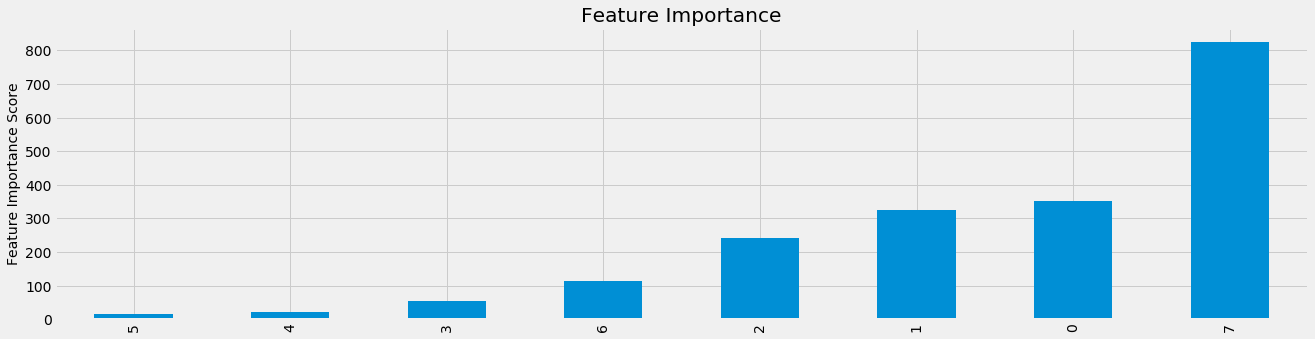

In [110]:
#fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],fe_df['event'],fe_df['PRECIP_TYP_ENC'],fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], fe_df['PRECIP_PRO'], fe_df['TEMP']
feat_label=['Hour of day','Day of week','Month of year','Event','Precip type','Rain intensity','Snow accum.','Precipitation probability','Temperature']
X_train_col=pd.DataFrame(X_train)
#FEATURE IMPORTANCE 
predictors = [x for x in X_train_col.columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=True)
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance',fontsize=14)
plt.ylabel('Feature Importance Score',fontsize=14)
plt.savefig('FIGS/feature_imp.pdf')

In [111]:
#fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],
                                #fe_df['event'],
                                #fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], 
                                #fe_df['PRECIP_PRO'], fe_df['TEMP']

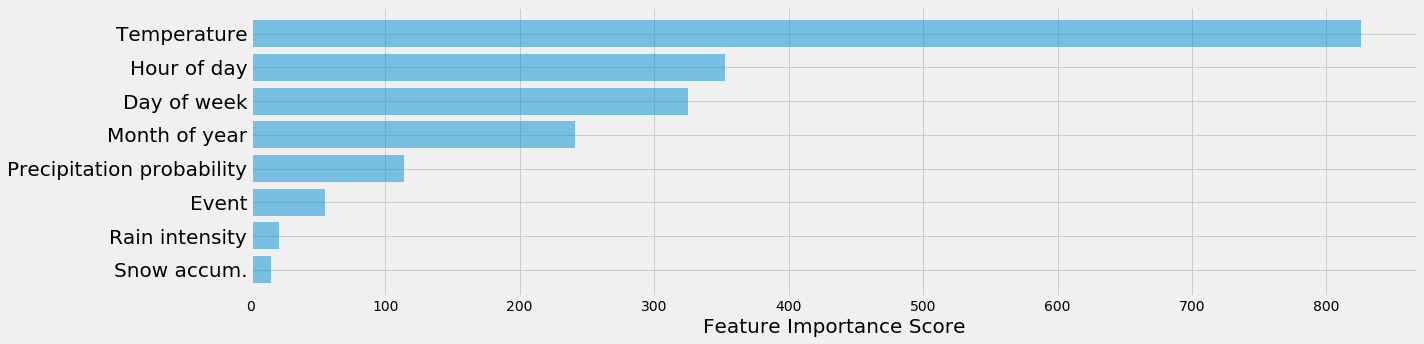

In [112]:
fig, ax = plt.subplots()

plt.style.use('fivethirtyeight')

feat_imp.values
feat_imp.index

feat_label=['Hour of day','Day of week','Month of year','Event','Rain intensity','Snow accum.','Precipitation probability','Temperature']

feat_imp_label=[feat_label[feat_imp.index[i]] for i in range(len(feat_label))]
feat_imp_data=feat_imp.values

y_pos = np.arange(len(feat_imp_data))

plt.barh(y_pos, feat_imp_data, align='center', alpha=0.5)
plt.yticks(y_pos, feat_imp_label)

plt.rcParams['figure.figsize'] = 20, 5
plt.plot(kind='bar',title='Feature Importance')
plt.xlabel('Feature Importance Score',fontsize=20)
ax.tick_params(axis="y", labelsize=20)

plt.tight_layout()
plt.savefig('FIGS/feature_imp_lbl.pdf')


In [22]:
# CV GRID SEARCH

estimator = lgb.LGBMRegressor()

# TEST STATION NUMBER # 

test_stations=[random.randint(0,len(MBTdelay_df)) for i in range(1)] # RANDOM INPUTS
# test_stations=[i for i in range(len(MBTdelay_df))] #  ALL 

for test_station_id_num in test_stations:
    
    param_grid = {
        'boosting' : ['gbdt', 'dart'],
        'num_leaves': [20, 30, 40, 50],
        'learning_rate': [0.05, 0.1, 0.12],
        'num_iterations': [50, 60, 80, 100],
        'learning_rate': [0.05, 0.10, 0.20]
    }

    gbm = GridSearchCV(estimator, param_grid, cv=3)
    gbm.fit(X_train, y_train)
    print('The rae of prediction is:', rae(y_test, y_pred)[1])
    print('The mse of prediction is:', metrics.mean_squared_error(y_test, y_pred))
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    print('The r2 of prediction is:', metrics.r2_score(y_test, y_pred))
    print('Best parameters found by grid search are:', gbm.best_params_)

KeyboardInterrupt: 

In [ ]:
# Best parameters found by grid search are: 
# {'bagging_fraction': 0.8, 'learning_rate': 0.12, 'n_estimators': 100, 'num_leaves': 8}

In [ ]:
# PRACTICE LOAD